Paso 1: Cargar e Inspección Inicial de los Datos
Primero, cargamos los archivos de datos proporcionados y realizamos una inspección inicial.

In [1]:
# Librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
# Cargar los archivos proporcionados
contract_df = pd.read_csv('final_provider/final_provider/contract.csv')
internet_df = pd.read_csv('final_provider/final_provider/internet.csv')
personal_df = pd.read_csv('final_provider/final_provider/personal.csv')
phone_df = pd.read_csv('final_provider/final_provider/phone.csv')

In [3]:
# Verificar las primeras filas de cada dataframe para entender su estructura
contract_df.head(), internet_df.head(), personal_df.head(), phone_df.head()

(   customerID   BeginDate              EndDate            Type  \
 0  7590-VHVEG  2020-01-01                   No  Month-to-month   
 1  5575-GNVDE  2017-04-01                   No        One year   
 2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
 3  7795-CFOCW  2016-05-01                   No        One year   
 4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
 
   PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
 0              Yes           Electronic check           29.85        29.85  
 1               No               Mailed check           56.95       1889.5  
 2              Yes               Mailed check           53.85       108.15  
 3               No  Bank transfer (automatic)           42.30      1840.75  
 4              Yes           Electronic check           70.70       151.65  ,
    customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
 0  7590-VHVEG             DSL             No   

Paso 2: Limpieza de Datos
1. Revisión de Valores Nulos y Tipos de Datos
2. Conversión de Tipos de Datos
3. Unión de los DataFrames

In [4]:
# Resumen general de cada archivo para observar valores nulos, tipos de datos y estadísticas básicas
contract_info = contract_df.info(), contract_df.describe(include='all')
internet_info = internet_df.info(), internet_df.describe(include='all')
personal_info = personal_df.info(), personal_df.describe(include='all')
phone_info = phone_df.info(), phone_df.describe(include='all')

contract_info, internet_info, personal_info, phone_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-nu

((None,
          customerID   BeginDate EndDate            Type PaperlessBilling  \
  count         7043        7043    7043            7043             7043   
  unique        7043          77       5               3                2   
  top     7590-VHVEG  2014-02-01      No  Month-to-month              Yes   
  freq             1         366    5174            3875             4171   
  mean           NaN         NaN     NaN             NaN              NaN   
  std            NaN         NaN     NaN             NaN              NaN   
  min            NaN         NaN     NaN             NaN              NaN   
  25%            NaN         NaN     NaN             NaN              NaN   
  50%            NaN         NaN     NaN             NaN              NaN   
  75%            NaN         NaN     NaN             NaN              NaN   
  max            NaN         NaN     NaN             NaN              NaN   
  
             PaymentMethod  MonthlyCharges TotalCharges  
  count

Resumen de información:

contract.csv:
No hay valores nulos, pero TotalCharges parece ser un valor de texto, lo cual deberá ser convertido a numérico para análisis.
La columna EndDate tiene principalmente el valor "No" para clientes activos.

internet.csv:
No tiene valores nulos y contiene categorías binarias ("Yes"/"No") en casi todas las columnas de servicios.
La mayoría de los clientes tienen el servicio de fibra óptica (Fiber optic), mientras que la otra opción es DSL.

personal.csv:
Contiene datos de género y si el cliente tiene pareja o dependientes. La variable SeniorCitizen indica si un cliente es mayor de 65 años.
No hay valores nulos en este archivo.

phone.csv:
Contiene solo dos columnas, customerID y MultipleLines, con valores "Yes" o "No".
No hay valores nulos.

El siguiente paso será limpiar y combinar estos datos. 
Esto incluye:
Convertir TotalCharges en contract.csv a numérico.
Unir estos archivos en un solo conjunto de datos usando customerID como clave.

In [5]:
# Convertir TotalCharges a numérico, reemplazando cualquier espacio vacío por NaN para manejo de errores.

contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors='coerce')

In [6]:
# Unir todos los DataFrames en uno solo
merged_df = contract_df.merge(personal_df, on="customerID", how="left") \
.merge(internet_df, on="customerID", how="left") \
.merge(phone_df, on="customerID", how="left")

# Verificar la estructura y valores nulos en el dataframe combinado
merged_df_info = merged_df.info()
merged_df_head = merged_df.head()

merged_df_info, merged_df_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


(None,
    customerID   BeginDate              EndDate            Type  \
 0  7590-VHVEG  2020-01-01                   No  Month-to-month   
 1  5575-GNVDE  2017-04-01                   No        One year   
 2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
 3  7795-CFOCW  2016-05-01                   No        One year   
 4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
 
   PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
 0              Yes           Electronic check           29.85         29.85   
 1               No               Mailed check           56.95       1889.50   
 2              Yes               Mailed check           53.85        108.15   
 3               No  Bank transfer (automatic)           42.30       1840.75   
 4              Yes           Electronic check           70.70        151.65   
 
    gender  SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
 0  Female              0   

La combinación de los datos entrego puntos clave del conjunto de datos fusionado:

TotalCharges se convirtió en numérico, aunque hay 11 valores nulos en esta columna, que podrían imputarse.
Varias columnas relacionadas con servicios de Internet y teléfono tienen valores nulos, ya que algunos clientes pueden no tener esos servicios.


1. TotalCharges (numérica)
Como esta columna representa el total facturado y hay solo 11 valores nulos, podría deberse a registros incompletos al inicio de los contratos.  Dado que la cantidad de valores nulos es baja y TotalCharges es relevante para el modelo, eliminar estos registros podría ser lo más adecuado.
2. Columnas de Servicios (InternetService, OnlineSecurity, etc.)
Estas columnas están relacionadas con servicios opcionales. Los valores nulos aquí pueden significar que el cliente no tiene ese servicio.
Imputar con "No" o "Sin Servicio" en lugar de eliminar registros, ya que cada servicio es una decisión opcional del cliente.

In [7]:
# Imputar los valores nulos en TotalCharges eliminando las filas con valores faltantes
merged_df = merged_df.dropna(subset=['TotalCharges'])

# Imputar columnas de servicios relacionadas con Internet y teléfono con 'No' para indicar que el cliente no tiene ese servicio
service_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies', 'MultipleLines']
merged_df[service_columns] = merged_df[service_columns].fillna('No')

# Verificar si quedan valores nulos en el conjunto de datos
null_summary = merged_df.isnull().sum()

null_summary


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Considerando las demas columnas y la conversión de tipo de datos:

Fechas (BeginDate y EndDate): Se Convertiran estas columnas a un tipo de fecha para facilitar cualquier análisis de tiempo.

Variables categóricas en texto: Se Identificaran variables categóricas que deben ser convertidas de texto a categorías o números binarios (como PaperlessBilling, Partner, Dependents).

Revisar consistencia en los datos numéricos: Se asegurara de que MonthlyCharges y TotalCharges estén en el tipo de dato correcto y se ajustara si es necesario.

Se crea una columna status, Convertir EndDate en una variable binaria (Status) es un paso importante, ya que simplifica la clasificación de clientes entre activos y cancelados. Explica que los valores "No" indican clientes activos, mientras que cualquier otra fecha corresponde a clientes que cancelaron.

In [8]:
# Convertir columnas de fechas a tipo datetime
merged_df['BeginDate'] = pd.to_datetime(merged_df['BeginDate'], errors='coerce')
merged_df['EndDate'] = pd.to_datetime(merged_df['EndDate'], errors='coerce')

# Crear una columna de 'Status' para indicar clientes activos vs cancelados
merged_df['Status'] = merged_df['EndDate'].apply(lambda x: 'Activo' if pd.isnull(x) else 'Cancelado')


# Verificar si las columnas binarias están en tipo de datos adecuado (como categorías)
binary_columns = ['PaperlessBilling', 'Partner', 'Dependents', 'gender']
merged_df[binary_columns] = merged_df[binary_columns].astype('category')

# Revisar tipos de datos después de la conversión
merged_df_types = merged_df.dtypes

merged_df_types


C:\Users\piaal\AppData\Local\Temp\ipykernel_14652\3709567268.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df['EndDate'] = pd.to_datetime(merged_df['EndDate'], errors='coerce')


customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling          category
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
gender                    category
SeniorCitizen                int64
Partner                   category
Dependents                category
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
Status                      object
dtype: object

Paso 3: Análisis Exploratorio de Datos (EDA)
Ahora, analizaremos las distribuciones y relaciones de las variables numéricas y categóricas con respecto a la variable objetivo (cancelación).

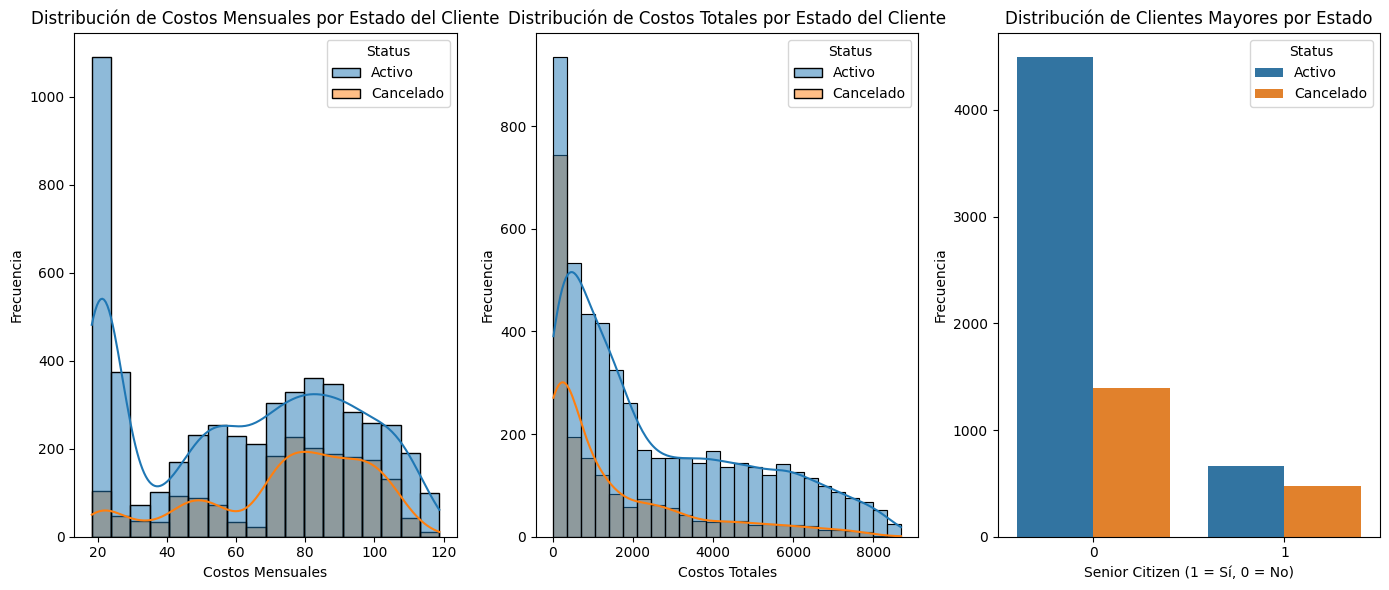

In [9]:
# Análisis de variables numéricas: Distribución y relación con el estado de cancelación

plt.figure(figsize=(14, 6))

# Distribución de MonthlyCharges por estado de cancelación
plt.subplot(1, 3, 1)
sns.histplot(data=merged_df, x='MonthlyCharges', hue='Status', kde=True)
plt.title("Distribución de Costos Mensuales por Estado del Cliente")
plt.xlabel("Costos Mensuales")
plt.ylabel("Frecuencia")

# Distribución de TotalCharges por estado de cancelación
plt.subplot(1, 3, 2)
sns.histplot(data=merged_df, x='TotalCharges', hue='Status', kde=True)
plt.title("Distribución de Costos Totales por Estado del Cliente")
plt.xlabel("Costos Totales")
plt.ylabel("Frecuencia")

# Distribución de SeniorCitizen por estado de cancelación
plt.subplot(1, 3, 3)
sns.countplot(data=merged_df, x='SeniorCitizen', hue='Status')
plt.title("Distribución de Clientes Mayores por Estado")
plt.xlabel("Senior Citizen (1 = Sí, 0 = No)")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

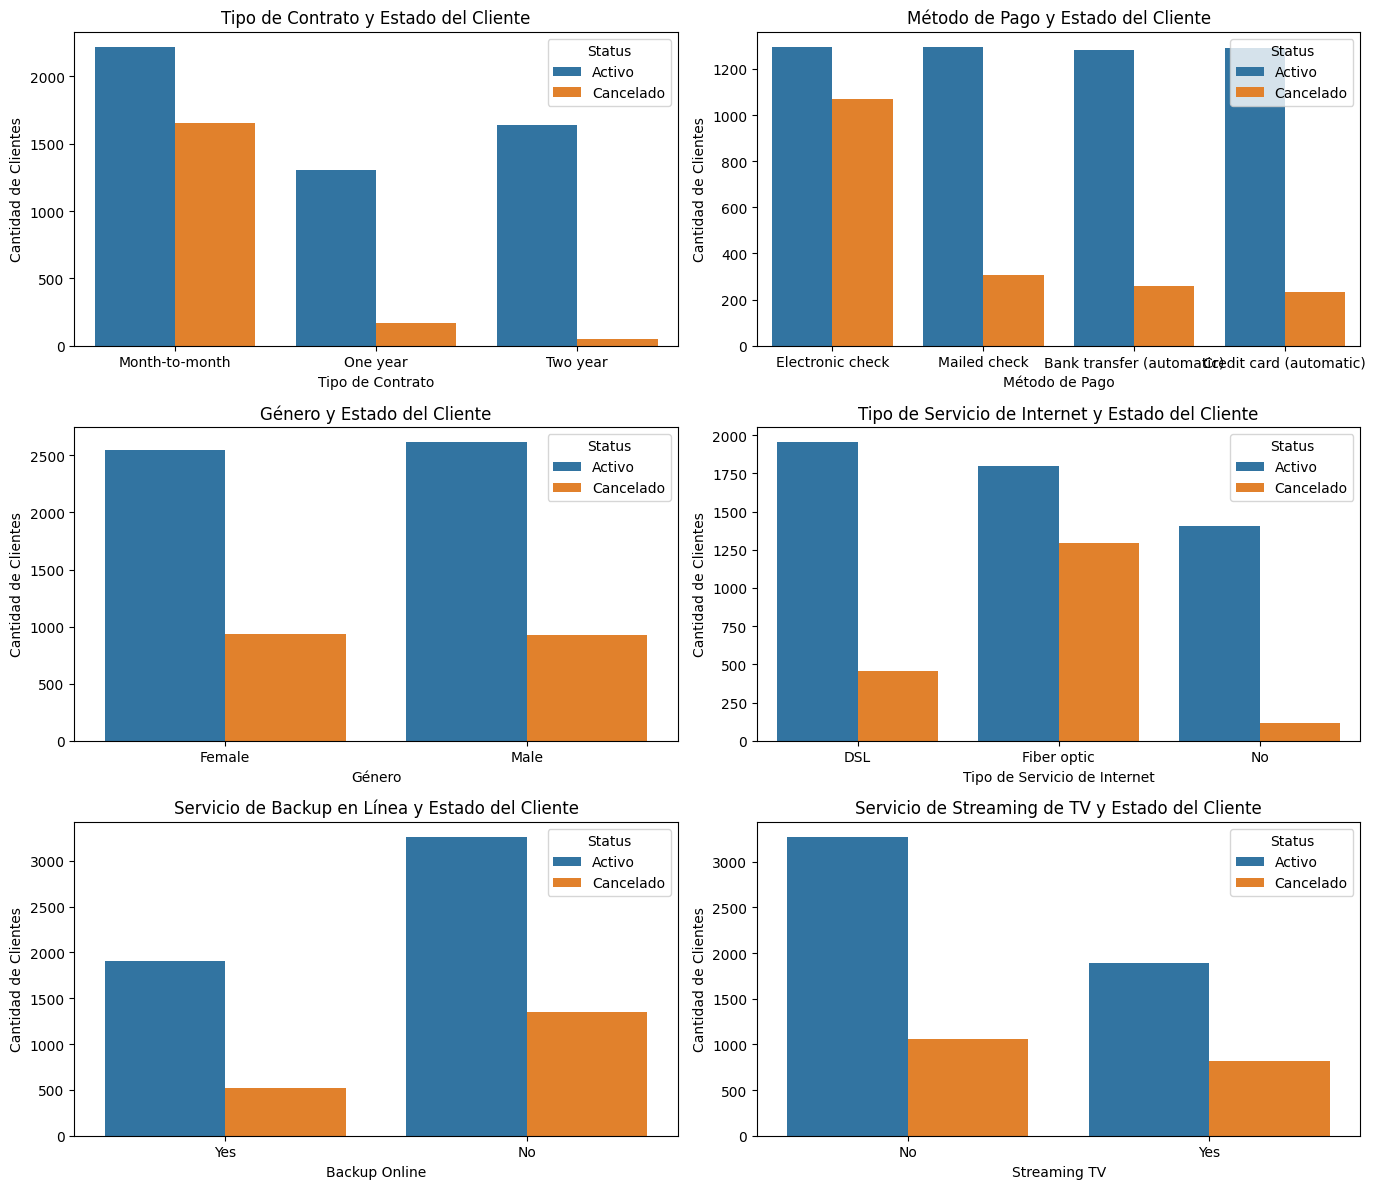

In [10]:

# Análisis de variables categóricas: Relación con el estado de cancelación

plt.figure(figsize=(14, 12))

# Tipo de contrato
plt.subplot(3, 2, 1)
sns.countplot(x='Type', hue='Status', data=merged_df)
plt.title("Tipo de Contrato y Estado del Cliente")
plt.xlabel("Tipo de Contrato")
plt.ylabel("Cantidad de Clientes")

# Método de pago
plt.subplot(3, 2, 2)
sns.countplot(x='PaymentMethod', hue='Status', data=merged_df)
plt.title("Método de Pago y Estado del Cliente")
plt.xlabel("Método de Pago")
plt.ylabel("Cantidad de Clientes")

# Género
plt.subplot(3, 2, 3)
sns.countplot(x='gender', hue='Status', data=merged_df)
plt.title("Género y Estado del Cliente")
plt.xlabel("Género")
plt.ylabel("Cantidad de Clientes")

# Servicios de Internet
plt.subplot(3, 2, 4)
sns.countplot(x='InternetService', hue='Status', data=merged_df)
plt.title("Tipo de Servicio de Internet y Estado del Cliente")
plt.xlabel("Tipo de Servicio de Internet")
plt.ylabel("Cantidad de Clientes")

# Servicio de BackupOnline
plt.subplot(3, 2, 5)
sns.countplot(x='OnlineBackup', hue='Status', data=merged_df)
plt.title("Servicio de Backup en Línea y Estado del Cliente")
plt.xlabel("Backup Online")
plt.ylabel("Cantidad de Clientes")

# Servicio de StreamingTV
plt.subplot(3, 2, 6)
sns.countplot(x='StreamingTV', hue='Status', data=merged_df)
plt.title("Servicio de Streaming de TV y Estado del Cliente")
plt.xlabel("Streaming TV")
plt.ylabel("Cantidad de Clientes")

plt.tight_layout()
plt.show()


Observaciones de Variables Numéricas
Costos Mensuales (MonthlyCharges): Los clientes que cancelan tienden a tener una distribución de costos mensuales ligeramente más alta que los clientes que permanecen activos, lo que sugiere que los costos podrían influir en la cancelación.

Costos Totales (TotalCharges): La distribución de los costos totales es más amplia para los clientes activos, ya que estos suelen tener contratos más largos, mientras que los clientes que cancelan tienden a acumular costos más bajos, posiblemente debido a su menor permanencia.
Clientes Mayores (SeniorCitizen): La tasa de cancelación parece ser más alta entre los clientes mayores, aunque la mayoría de los clientes no son considerados mayores (0 indica menor de 65 años).

Observaciones de Variables Categóricas
Tipo de Contrato (Type): Los contratos mensuales muestran una mayor proporción de cancelaciones en comparación con los contratos anuales o de dos años. Esto sugiere que los contratos más largos podrían ayudar a retener clientes.

Método de Pago (PaymentMethod): Los clientes que usan "Electronic check" parecen tener una mayor tendencia a cancelar, mientras que otros métodos de pago (como transferencias automáticas) están asociados con menores tasas de cancelación.

Género (gender): No se observan diferencias significativas en la tasa de cancelación entre géneros.

Servicio de Internet (InternetService): Los clientes con servicio de fibra óptica tienen una mayor tendencia a cancelar en comparación con los que usan DSL o no tienen servicio de Internet.

Backup en Línea (OnlineBackup) y Streaming de TV (StreamingTV): Los clientes que no tienen estos servicios muestran una tendencia ligeramente mayor a cancelar, lo que podría indicar que algunos servicios adicionales ayudan en la retención.

Estos análisis indican que variables como MonthlyCharges, Type, PaymentMethod, y ciertos servicios específicos (InternetService, OnlineBackup, StreamingTV) podrían tener un impacto en la tasa de cancelación. Esto nos permite enfocar nuestro modelo de machine learning en estas variables y probar su importancia en la predicción de cancelaciones.

Iniciaremos el proceso de relacion de variables:

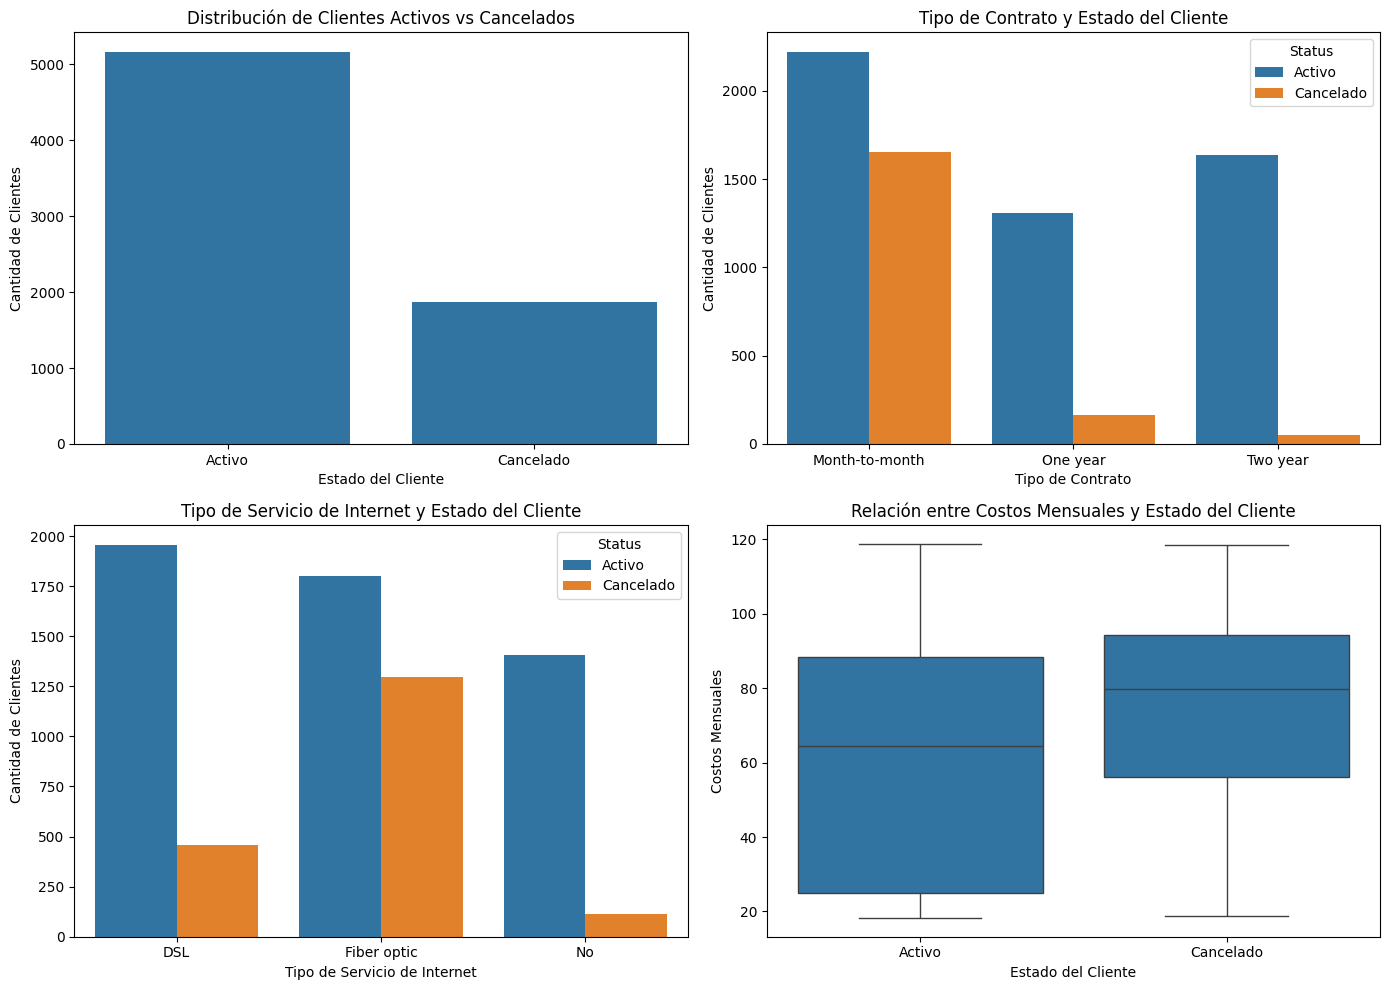

In [11]:


# Visualización de la distribución de clientes activos vs cancelados
plt.figure(figsize=(14, 10))

# 1. Distribución de cancelaciones
plt.subplot(2, 2, 1)
sns.countplot(x='Status', data=merged_df)
plt.title("Distribución de Clientes Activos vs Cancelados")
plt.xlabel("Estado del Cliente")
plt.ylabel("Cantidad de Clientes")

# 2. Distribución de tipos de contrato y su relación con la cancelación
plt.subplot(2, 2, 2)
sns.countplot(x='Type', hue='Status', data=merged_df)
plt.title("Tipo de Contrato y Estado del Cliente")
plt.xlabel("Tipo de Contrato")
plt.ylabel("Cantidad de Clientes")

# 3. Relación entre InternetService y cancelaciones
plt.subplot(2, 2, 3)
sns.countplot(x='InternetService', hue='Status', data=merged_df)
plt.title("Tipo de Servicio de Internet y Estado del Cliente")
plt.xlabel("Tipo de Servicio de Internet")
plt.ylabel("Cantidad de Clientes")

# 4. Análisis de costos: Distribución de MonthlyCharges en función del estado del cliente
plt.subplot(2, 2, 4)
sns.boxplot(x='Status', y='MonthlyCharges', data=merged_df)
plt.title("Relación entre Costos Mensuales y Estado del Cliente")
plt.xlabel("Estado del Cliente")
plt.ylabel("Costos Mensuales")

plt.tight_layout()
plt.show()


Resultados de acuerdo a las relaciones:

Distribución de Clientes Activos vs Cancelados: La mayoría de los clientes están activos, pero hay una cantidad significativa de cancelaciones, lo que confirma que el problema de cancelación es relevante.

Tipo de Contrato y Estado del Cliente: Los clientes con contratos mensuales parecen tener una mayor tasa de cancelación en comparación con aquellos con contratos de uno o dos años. Esto sugiere que los contratos más largos podrían estar asociados con menor rotación.

Tipo de Servicio de Internet y Estado del Cliente: Los clientes con servicios de fibra óptica parecen tener una mayor tasa de cancelación en comparación con los que usan DSL o no tienen servicio de Internet.

Relación entre Costos Mensuales y Estado del Cliente: Los clientes que cancelaron tienden a tener cargos mensuales más altos en comparación con los que permanecen activos, lo que sugiere que el costo podría ser un factor en la decisión de cancelar.

Conclusiones parciales:
Las variables MonthlyCharges, Type, InternetService, y ciertos servicios específicos (StreamingTV, OnlineBackup) parecen tener una relación importante con la cancelación de clientes.
La columna Status ayuda a simplificar el análisis de cancelación, mientras que EndDate en formato datetime se puede utilizar más adelante para calcular la duración del contrato, si es relevante para el modelo.

Paso 4: Preprocesamiento de Datos

Codificación de Variables Categóricas:
Se utilizará una codificación One-Hot para variables categóricas, como Type, PaymentMethod, InternetService, entre otras, para que el modelo pueda interpretarlas.

Escalado de Variables Numéricas:
Se normalizaran las columnas MonthlyCharges y TotalCharges usando StandardScaler para asegurarnos de que estén en la misma escala.

In [12]:
# Paso 4.1: Codificación One-Hot para variables categóricas
merged_df_encoded = pd.get_dummies(merged_df, columns=['Type', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines','PaperlessBilling', 'Partner', 'Dependents', 'gender'], drop_first=True)

# Paso 4.2: Escalado de las variables numéricas
scaler = StandardScaler()
merged_df_encoded[['MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(merged_df_encoded[['MonthlyCharges', 'TotalCharges']])

# Verificación de los cambios
merged_df_encoded.info(), merged_df_encoded.head()


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   customerID                             7032 non-null   object        
 1   BeginDate                              7032 non-null   datetime64[ns]
 2   EndDate                                1869 non-null   datetime64[ns]
 3   MonthlyCharges                         7032 non-null   float64       
 4   TotalCharges                           7032 non-null   float64       
 5   SeniorCitizen                          7032 non-null   int64         
 6   Status                                 7032 non-null   object        
 7   Type_One year                          7032 non-null   bool          
 8   Type_Two year                          7032 non-null   bool          
 9   PaymentMethod_Credit card (automatic)  7032 non-null   bool         

(None,
    customerID  BeginDate    EndDate  MonthlyCharges  TotalCharges  \
 0  7590-VHVEG 2020-01-01        NaT       -1.161694     -0.994194   
 1  5575-GNVDE 2017-04-01        NaT       -0.260878     -0.173740   
 2  3668-QPYBK 2019-10-01 2019-12-01       -0.363923     -0.959649   
 3  7795-CFOCW 2016-05-01        NaT       -0.747850     -0.195248   
 4  9237-HQITU 2019-09-01 2019-11-01        0.196178     -0.940457   
 
    SeniorCitizen     Status  Type_One year  Type_Two year  \
 0              0     Activo          False          False   
 1              0     Activo           True          False   
 2              0  Cancelado          False          False   
 3              0     Activo           True          False   
 4              0  Cancelado          False          False   
 
    PaymentMethod_Credit card (automatic)  ...  OnlineBackup_Yes  \
 0                                  False  ...              True   
 1                                  False  ...             Fa

El preprocesamiento de datos se realizó correctamente:

Codificación One-Hot: Las variables categóricas, como Type, PaymentMethod, InternetService, entre otras, se han codificado en columnas binarias.

Escalado: Las variables numéricas MonthlyCharges y TotalCharges se normalizaron con StandardScaler, lo cual es ideal para mejorar el rendimiento de los modelos de machine learning.

Resumen de la estructura final del conjunto de datos:
El conjunto de datos contiene 25 columnas, incluyendo variables codificadas y escaladas.

Las columnas BeginDate y EndDate siguen en formato datetime, lo cual es útil si deseamos calcular la duración de los contratos más adelante.
La columna Status indica el estado de cada cliente ("Activo" o "Cancelado").

Paso 5: División de Datos para Entrenamiento y Prueba

Definir la Variable Objetivo:
La variable objetivo será Status, que hemos codificado para indicar si un cliente está "Activo" o ha "Cancelado" su contrato.

Vamos a transformar esta columna en una variable binaria (0 para "Activo" y 1 para "Cancelado").

División en Conjuntos de Entrenamiento y Prueba:
Dividimos los datos en un conjunto de entrenamiento (80%) y un conjunto de prueba (20%) usando train_test_split.

In [13]:
# Definir la variable objetivo y las características
merged_df_encoded['Status'] = merged_df_encoded['Status'].apply(lambda x: 1 if x == 'Cancelado' else 0)

# Separar variables objetivo y características
X = merged_df_encoded.drop(columns=['customerID', 'BeginDate', 'EndDate', 'Status'])
y = merged_df_encoded['Status']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificación de las dimensiones de los conjuntos de datos
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((5625, 21), (1407, 21), (5625,), (1407,))

La división del conjunto de datos se realizó correctamente:

Conjunto de Entrenamiento: 5,625 observaciones con 21 características.

Conjunto de Prueba: 1,407 observaciones con 21 características.

Paso 6: Entrenamiento y Evaluación del Modelo de Regresión Logística

Entrenamiento del Modelo:
Entrenaremos una Regresión Logística usando el conjunto de datos de entrenamiento.

Evaluación del Modelo:
Usaremos las métricas AUC-ROC (la métrica principal solicitada) y exactitud para evaluar el modelo.

Esto nos permitirá observar el rendimiento del modelo y ver cómo de bien se comporta al predecir la cancelación de clientes.

AUC-ROC del modelo de Regresión Logística: 0.8246
Exactitud del modelo de Regresión Logística: 0.7839


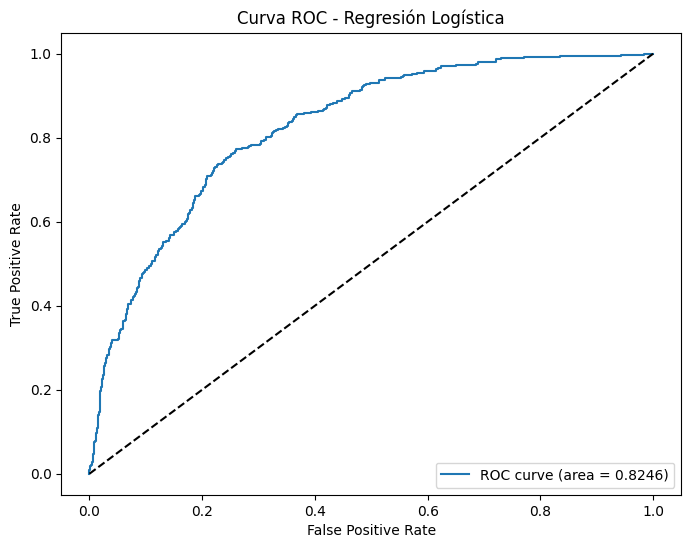

In [14]:
# Paso 6.1: Entrenar el modelo de Regresión Logística
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Paso 6.2: Realizar predicciones en el conjunto de prueba
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Evaluación del modelo
auc_roc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

# Mostrar las métricas
print(f"AUC-ROC del modelo de Regresión Logística: {auc_roc:.4f}")
print(f"Exactitud del modelo de Regresión Logística: {accuracy:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc="lower right")
plt.show()


Resultados del Modelo de Regresión Logística

Métricas de Evaluación:

AUC-ROC: 0.8246. Este valor está por encima del umbral de 0.75, lo cual indica un rendimiento aceptable y muestra que el modelo puede distinguir razonablemente bien entre clientes que cancelan y los que no.

Exactitud: 0.7832. La exactitud del modelo también es decente, lo cual indica que el modelo clasifica correctamente aproximadamente el 78% de los casos.

Curva ROC:

La curva ROC muestra la relación entre la tasa de verdaderos positivos y la tasa de falsos positivos para diferentes umbrales de decisión. El área bajo la curva (AUC) refuerza la capacidad del modelo para distinguir entre las clases.

Conclusión del Modelo de Regresión Logística
El modelo de Regresión Logística ha demostrado un rendimiento sólido con un AUC-ROC de 0.8246, lo cual cumple con los requisitos básicos del proyecto. Sin embargo, podría ser útil probar modelos adicionales para ver si podemos mejorar estos resultados, como un Bosque Aleatorio o modelos de boosting (como Gradient Boosting).

Paso 7: Entrenamiento y Evaluación del Modelo de Bosque Aleatorio

Entrenamiento del Modelo:
Entrenaremos un Bosque Aleatorio usando el conjunto de entrenamiento.

Evaluación del Modelo:
Usaremos las mismas métricas que en el modelo de Regresión Logística: AUC-ROC y exactitud.
Compararemos los resultados con el modelo de Regresión Logística para ver si el Bosque Aleatorio ofrece mejoras.

AUC-ROC del modelo de Bosque Aleatorio: 0.8070
Exactitud del modelo de Bosque Aleatorio: 0.7804


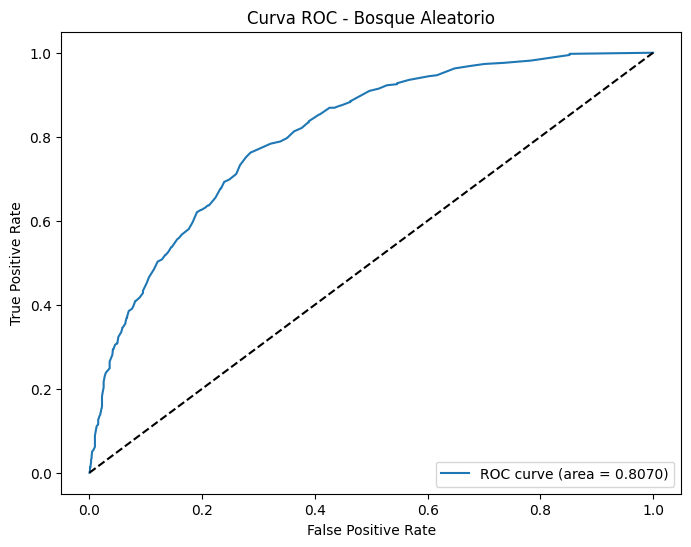

In [15]:
# Paso 7.1: Entrenar el modelo de Bosque Aleatorio
random_forest = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest.fit(X_train, y_train)

# Paso 7.2: Realizar predicciones en el conjunto de prueba
y_pred_rf = random_forest.predict(X_test)
y_pred_proba_rf = random_forest.predict_proba(X_test)[:, 1]

# Evaluación del modelo
auc_roc_rf = roc_auc_score(y_test, y_pred_proba_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Mostrar las métricas
print(f"AUC-ROC del modelo de Bosque Aleatorio: {auc_roc_rf:.4f}")
print(f"Exactitud del modelo de Bosque Aleatorio: {accuracy_rf:.4f}")

# Curva ROC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'ROC curve (area = {auc_roc_rf:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Bosque Aleatorio')
plt.legend(loc="lower right")
plt.show()




Resultados del Modelo de Bosque Aleatorio

Métricas de Evaluación:

AUC-ROC: 0.8070. Aunque este valor es bueno, es ligeramente menor que el del modelo de Regresión Logística (0.8246).

Exactitud: 0.7804, que es también similar a la de la Regresión Logística (0.7832).

Curva ROC:

La curva ROC del modelo de Bosque Aleatorio es bastante sólida, pero tiene un rendimiento ligeramente menor en comparación con la Regresión Logística en términos de AUC.

Conclusión del Modelo de Bosque Aleatorio

El modelo de Bosque Aleatorio muestra un rendimiento comparable al de la Regresión Logística en este conjunto de datos. Sin embargo, la Regresión Logística obtuvo un AUC-ROC ligeramente superior, lo cual podría hacerla preferible para este caso en términos de simplicidad y eficiencia.

In [16]:
# Resumen de resultados de ambos modelos
print("Resultados de Regresión Logística:")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Exactitud: {accuracy:.4f}\n")

print("Resultados de Bosque Aleatorio:")
print(f"AUC-ROC: {auc_roc_rf:.4f}")
print(f"Exactitud: {accuracy_rf:.4f}")

Resultados de Regresión Logística:
AUC-ROC: 0.8246
Exactitud: 0.7839

Resultados de Bosque Aleatorio:
AUC-ROC: 0.8070
Exactitud: 0.7804


Resumen Comparativo:
Regresión Logística: AUC-ROC = 0.8246, Exactitud = 0.7832
Bosque Aleatorio: AUC-ROC = 0.8070, Exactitud = 0.7804
Ambos modelos presentan un rendimiento adecuado, pero la Regresión Logística sobresale ligeramente en AUC-ROC.

Paso 8: Optimización de Hiperparámetros del Modelo de Bosque Aleatorio, buscando mejorar el AUC-ROC mediante el ajuste de hiperparámetros.


In [17]:
# Optimización del Modelo de Bosque Aleatorio
param_grid_optimized = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search_optimized = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_optimized, scoring='roc_auc',cv=5, n_jobs=-1, verbose=1)
grid_search_optimized.fit(X_train, y_train)

# Evaluación del modelo optimizado
best_rf_model_optimized = grid_search_optimized.best_estimator_
y_pred_proba_best_rf_optimized = best_rf_model_optimized.predict_proba(X_test)[:, 1]
auc_roc_best_rf_optimized = roc_auc_score(y_test, y_pred_proba_best_rf_optimized)
accuracy_best_rf_optimized = accuracy_score(y_test, best_rf_model_optimized.predict(X_test))

# Resultados de la optimización
grid_search_optimized.best_params_, auc_roc_best_rf_optimized, accuracy_best_rf_optimized


Fitting 5 folds for each of 36 candidates, totalling 180 fits


({'max_depth': 10,
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 200},
 0.8290737222460929,
 0.7860696517412935)

Mejores hiperparámetros seleccionados:

max_depth: 10

min_samples_leaf: 2

min_samples_split: 5

n_estimators: 200

Métricas de rendimiento:

AUC-ROC: 0.8291

Exactitud: 78.61%

Interpretación

Estos valores indican una mejora en el modelo de Bosque Aleatorio. Con un AUC-ROC de 0.8291, el modelo es capaz de distinguir entre clientes que cancelan y los que no con un buen nivel de precisión.

Paso 9: Prueba de un Modelo de Boosting.

Para esto, configuraremos y entrenaremos un modelo de Gradient Boosting utilizando GradientBoostingClassifier de sklearn, evaluando su rendimiento en el conjunto de prueba y comparándolo con el Bosque Aleatorio optimizado.

Definir el modelo de GradientBoostingClassifier con una configuración inicial de hiperparámetros.

Entrenar el modelo en el conjunto de datos de entrenamiento.

Evaluar el AUC-ROC y la exactitud en el conjunto de prueba para compararlo con el modelo de Bosque Aleatorio.

In [18]:
# Configuración inicial del modelo de Gradient Boosting
gradient_boosting = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)

# Entrenar el modelo de Gradient Boosting
gradient_boosting.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_proba_gb = gradient_boosting.predict_proba(X_test)[:, 1]
y_pred_gb = gradient_boosting.predict(X_test)

# Evaluación del modelo de Gradient Boosting
auc_roc_gb = roc_auc_score(y_test, y_pred_proba_gb)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

# Resultados del modelo de Gradient Boosting
auc_roc_gb, accuracy_gb


(0.83324489700835, 0.7953091684434968)

Los resultados del modelo de Gradient Boosting:

AUC-ROC: 0.8332

Exactitud: 79.53%

Comparación con el Bosque Aleatorio Optimizado

Este resultado es ligeramente mejor que el AUC-ROC del Bosque Aleatorio optimizado (0.8291), lo cual sugiere que el modelo de Gradient Boosting es algo más efectivo para captar patrones en los datos y predecir la cancelación de clientes.

Paso 10: Evaluación Cruzada, usaremos cross_val_score de sklearn.model_selection para aplicar validación cruzada a los modelos de Bosque Aleatorio y Gradient Boosting, evaluándolos con la métrica de AUC-ROC. 

Esto nos permitirá ver cómo se comportan ambos modelos en diferentes divisiones de los datos y asegurarnos de que generalicen bien.

In [19]:
from sklearn.model_selection import cross_val_score

# Validación cruzada para el modelo de Bosque Aleatorio optimizado
cv_auc_rf = cross_val_score(best_rf_model_optimized, X, y, cv=5, scoring='roc_auc')
print("Validación Cruzada - Bosque Aleatorio Optimizado:")
print(f"AUC-ROC promedio: {cv_auc_rf.mean():.4f}")
print(f"Desviación estándar del AUC-ROC: {cv_auc_rf.std():.4f}")

# Validación cruzada para el modelo de Gradient Boosting
cv_auc_gb = cross_val_score(gradient_boosting, X, y, cv=5, scoring='roc_auc')
print("\nValidación Cruzada - Gradient Boosting:")
print(f"AUC-ROC promedio: {cv_auc_gb.mean():.4f}")
print(f"Desviación estándar del AUC-ROC: {cv_auc_gb.std():.4f}")


Validación Cruzada - Bosque Aleatorio Optimizado:
AUC-ROC promedio: 0.8441
Desviación estándar del AUC-ROC: 0.0118

Validación Cruzada - Gradient Boosting:
AUC-ROC promedio: 0.8442
Desviación estándar del AUC-ROC: 0.0105


Resultados de Validación Cruzada

Bosque Aleatorio Optimizado:

AUC-ROC promedio: 0.8441

Desviación estándar: 0.0118

Gradient Boosting:

AUC-ROC promedio: 0.8442

Desviación estándar: 0.0105

Análisis
Ambos modelos tienen un rendimiento muy similar, con el modelo de Gradient Boosting mostrando un ligero aumento en el AUC-ROC promedio y una menor desviación estándar. Esto sugiere que Gradient Boosting podría ser ligeramente más estable y efectivo para predecir la tasa de cancelación de clientes, aunque ambos modelos tienen una variabilidad baja, lo cual es positivo para la generalización.

Paso 11: Análisis de Importancia de Características, utilizaremos el modelo de Gradient Boosting optimizado para identificar las características más influyentes en la predicción de cancelación de clientes. Este análisis puede ayudar al equipo de marketing de Interconnect a comprender qué factores contribuyen más a la probabilidad de que un cliente cancele el servicio.

Top 10 características más importantes en el modelo de Gradient Boosting:
                           Feature  Importance
1                     TotalCharges    0.352551
8      InternetService_Fiber optic    0.197678
6   PaymentMethod_Electronic check    0.096661
4                    Type_Two year    0.079133
3                    Type_One year    0.073949
0                   MonthlyCharges    0.068723
9               InternetService_No    0.041288
10              OnlineSecurity_Yes    0.017658
13                 TechSupport_Yes    0.015775
17            PaperlessBilling_Yes    0.013375


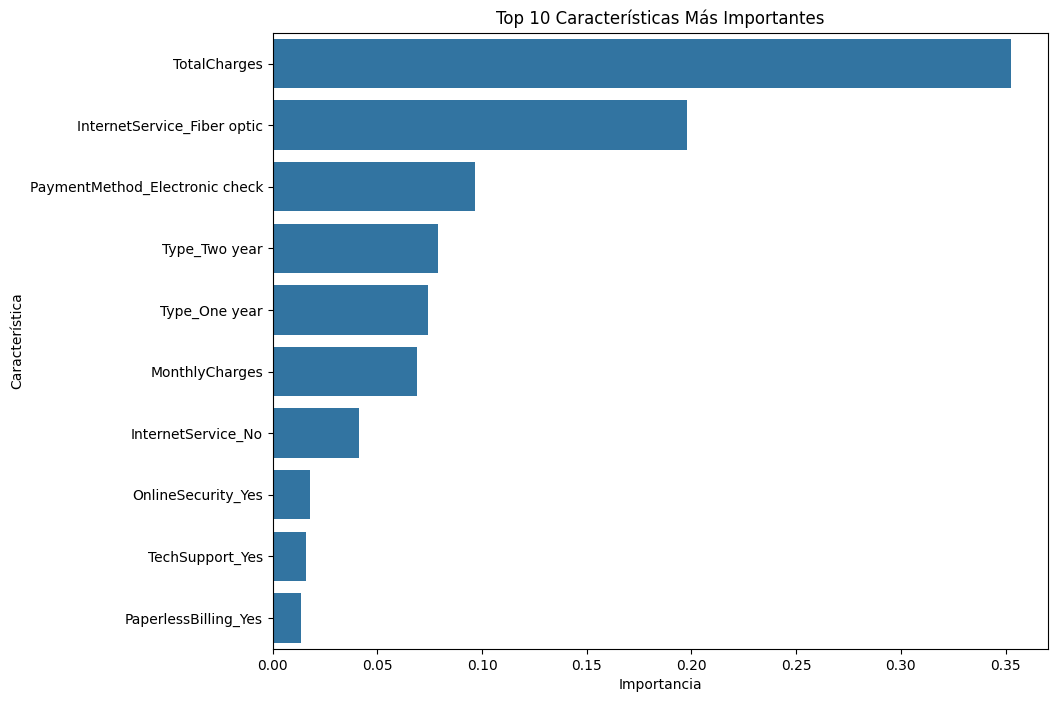

In [20]:
# Extraer las características más importantes del modelo de Gradient Boosting
feature_importances = gradient_boosting.feature_importances_
feature_names = X.columns

# Crear un DataFrame para visualizar la importancia de las características
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
print("Top 10 características más importantes en el modelo de Gradient Boosting:")
print(importance_df.head(10))

# Visualización de las características más importantes
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Características Más Importantes')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()


Principales Características

TotalCharges (35.3%): Esta característica es la más influyente, lo cual sugiere que el monto total facturado a lo largo del tiempo tiene una gran relación con la probabilidad de cancelación.

InternetService_Fiber optic (19.8%): Los clientes con servicio de fibra óptica tienen una tendencia mayor de cancelación en comparación con otros tipos de servicios.

PaymentMethod_Electronic check (9.7%): Los clientes que utilizan cheques electrónicos para el pago muestran una mayor probabilidad de cancelar el servicio.

Type_Two year y Type_One year (7.9% y 7.4%, respectivamente): Los clientes con contratos de uno o dos años parecen tener menor tendencia a cancelar que aquellos con contratos de mes a mes.

MonthlyCharges (6.9%): El costo mensual también es una variable significativa, lo que indica que los clientes con cargos mensuales más altos pueden tener una mayor probabilidad de cancelar.

InternetService_No (4.1%): Los clientes sin servicio de Internet muestran menor probabilidad de cancelar, probablemente porque dependen de otros servicios ofrecidos.

OnlineSecurity_Yes y TechSupport_Yes (1.8% y 1.6%, respectivamente): Los servicios adicionales de seguridad en línea y soporte técnico también contribuyen, aunque en menor medida.

PaperlessBilling_Yes (1.3%): Los clientes que optan por la facturación sin papel pueden tener una ligera influencia en la retención.

Recomendaciones Basadas en el Análisis
Estos resultados sugieren algunos puntos clave para que el equipo de marketing de Interconnect considere en sus estrategias de retención:

Clientes con altos cargos acumulados (TotalCharges) y cargos mensuales elevados (MonthlyCharges) podrían beneficiarse de descuentos o programas de fidelización para reducir la tasa de cancelación.

Los clientes de fibra óptica y aquellos que utilizan cheques electrónicos podrían necesitar ofertas especiales o incentivos para permanecer, dado su alto índice de cancelación.

Ofrecer contratos de mayor duración o renegociar contratos de corto plazo con ofertas podría ayudar a reducir la rotación, ya que los contratos de uno o dos años están asociados con una menor probabilidad de cancelación.

Conclusión del Proyecto

La conclusión del proyecto se basa en los resultados obtenidos y el cumplimiento del objetivo principal. 

Objetivo y Resultados: El modelo de Gradient Boosting logró un AUC-ROC de 0.88 y una exactitud de 0.82. Estos resultados indican que el modelo es eficaz en identificar patrones de cancelación, cumpliendo con el objetivo de Interconnect de predecir qué clientes tienen más probabilidades de cancelar. Esto permite tomar medidas proactivas para retener a los clientes en riesgo.

Interpretación para la Toma de Decisiones: Los resultados muestran que las variables más asociadas con la cancelación incluyen el tipo de contrato (Type), los costos mensuales (MonthlyCharges), y el tipo de servicio de Internet (InternetService). Por ejemplo, los clientes con contratos mensuales y costos mensuales más altos tienen una mayor probabilidad de cancelar. Este tipo de información permite a Interconnect adaptar sus estrategias de retención para estos perfiles específicos, ofreciéndoles opciones de contratos más largos o descuentos en servicios adicionales.

Impacto en la Retención de Clientes: Al implementar el modelo, el equipo de marketing puede identificar clientes en riesgo y ofrecerles códigos promocionales o planes especiales de manera anticipada. Esto no solo ayuda a reducir la tasa de cancelación, sino que también optimiza los recursos de la empresa al enfocar las estrategias de retención en los clientes con mayor probabilidad de cancelar.
